# Scikit-optimize

Sequential model-based optimization in Python

> * Sequential model-based optimization
> * Built on Numpy, Scipy, and Scikit-Learn
> * Open source, commercially usable - BSD license

## 0. Getting started

* 순차적 모델 기반의 최적화를 지원하는 패키지
* 쉽게 사용 가능하며 단순 명료한 사용
* gradient 기반의 최적화를 지원하지는 않음

In [1]:
import skopt
skopt.__version__

'0.9.0'

### Finding a minimum

In [2]:
import numpy as np
from skopt import gp_minimize
np.random.seed(123)

def f(x):
    return (np.sin(5 * x[0])*(1 - np.tanh(x[0] ** 2)) * np.random.randn()*0.1)

res = gp_minimize(f, [(-2.0, 2.0)], n_calls = 20)
print("x*=%.2f f(x*)=%.2f" % (res.x[0], res.fun))

x*=0.85 f(x*)=-0.06


skopt.Optimizer 클래스 이용, 최적화 실시

In [3]:
from skopt import Optimizer
opt = Optimizer([(-2.0, 2.0)])

for i in range(20):
    suggested = opt.ask()
    y = f(suggested)
    res = opt.tell(suggested, y)
    
print("x*=%.2f f(x*)=%.2f" %(res.x[0], res.fun))

x*=0.27 f(x*)=-0.15


## 1. BayesSearchCV

### Introduction

* 사이킷런의 기본 크로스밸리데이션 서칭 방법은 그리드서치 방식(GridSearchCV)임 -> 이는 하이퍼파라미터가 증가하면 계산량이 기하급수적으로 증가하는 단점이 있음

* 이를 개선하고자 임의탐색 방식(RandomizedSearchCV)이 있음

* 베이지안서치 방식은 

> * 목적함수의 min 혹은 max 값을 찾기 위한 방법으로 
> * 목적함수(objective function)란 보통 입력값 x 에 대한 미지의 함수 f(x)를 의미하며 보통은 목적 함수의 표현식을 정확히 알지 못하므로 black-box function이라고 표현함
> * surrogate model: 현재까지 얻은 Y = f(x)를 바탕으로 미지의 목적 함수의 형태에 대한 확률적 추정 모델 
> * Acquisition Function: 목적 함수에 대한 현재까지의 추정을 기반으로 다음 입력값 후보를 추천하는 함수
> * 지금까지의 정보를 기반으로 Bayesian Optimization 수행 과정을 글로 표현하면 
```python
for t = 1,2,... do
    기존 (x1, f(x1)), (x2, f(x2)), ... (xt, f(xt)) 데이터셋에 대한 Surrogate model의 확률적 추정을 기반으로
    Acquisition function을 최대화하는 다음 후보 xt+1을 선정한다
    xt+1에 대한 f(xt+1)을 계산한다.
    기존 데이터셋에 (xt+1, f(xt+1))을 추가하고 Surrogate model의 확률적 추정을 다시 수행한다.
end for
```    
> * 이를 sudo code 형태로 표현하면 
```python 
for t = 1,2,... do
    X, Y = [x1, ..., xt], [y1, ..., yt]
    x(t+1) = max(surrogate_model.predict, [Xsample1, Xsample2, ...])
    y(t+1) = f(x(t+1))
    X.append(x(t+1)), Y.append(y(t+1))
    surrogate_model.fit(X(t+1), y(t+1))
end for
```

### Minimal example

In [4]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


In [5]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'), # Reguliazation parameter, 노이즈가 많은 환경에서 C 값을 줄이면 regulaization을 더함
        'gamma': (1e-6, 1e+1, 'log-uniform'), # rbf kernel의 파라미터 
        'degree': (1, 8),  # integer valued parameter, polynomial kernel 파라미터
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter, 커널 종류 선택 (sigmoid 는 생략)
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


val. score: 0.985894580549369
test score: 0.9822222222222222


### Advanced example

In [6]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.datasets import load_digits
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class = 10, return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

# pipeline class is used as estimator to enable
# search over different model types
pipe = Pipeline([('model', SVC())])

# single categorical value of 'model' parameter is sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned
# But that's fine, this is just an example
linsvc_search = {
    'model' : [LinearSVC(max_iter=1000)],
    'model__C' : (1e-6, 1e+6, 'log-uniform'),    
}

# explicit dimension classes can be specified like this
svc_search = {
    'model': Categorical([SVC()]),
    'model__C': Real(1e-6, 1e+6, prior = 'log-uniform'),
    'model__gamma': Real(1e-6, 1e+1, prior = 'log-uniform'),
    'model__degree': Integer(1, 8),
    'model__kernel': Categorical(['linear', 'poly', 'rbf']),
}

opt = BayesSearchCV(
        pipe,
        # (parameter space, # of eavluations)
        [(svc_search, 40), (linsvc_search, 16)],
        cv = 3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number 

val. score: 0.985894580549369
test score: 0.9822222222222222
best params: OrderedDict([('model', SVC(C=0.41571471424085416, gamma=1.0560013164213486, kernel='poly')), ('model__C', 0.41571471424085416), ('model__degree', 3), ('model__gamma', 1.0560013164213486), ('model__kernel', 'poly')])


목적 함수의 종속성 플랏의 일부(for SVC 모델)

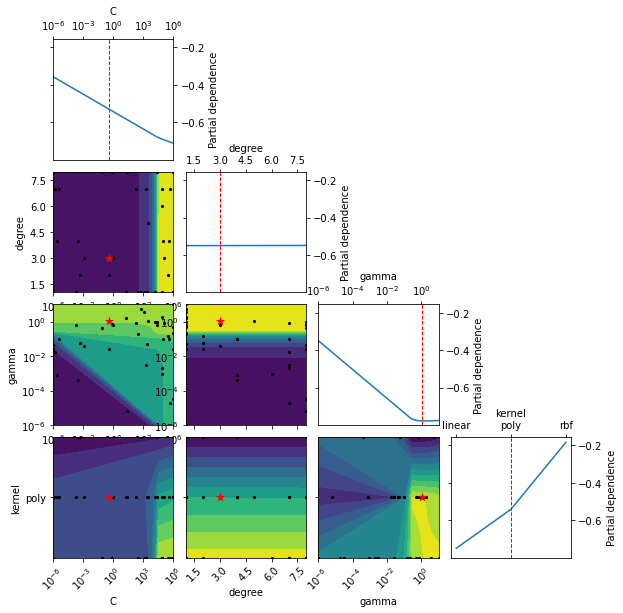

In [7]:
_ = plot_objective(opt.optimizer_results_[0],
                    dimensions = ["C", "degree", "gamma", "kernel"],
                    n_minimum_search = int(1e8))
plt.show()

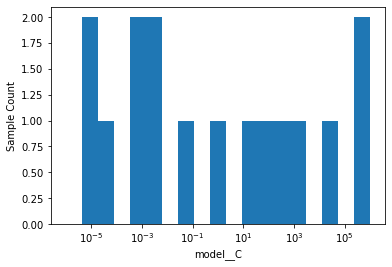

In [8]:
_ = plot_histogram(opt.optimizer_results_[1], 1)
plt.show()

### Progress monitoring and control using `callback` argument of `fit` method

In [9]:
from skopt import BayesSearchCV
from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y =load_iris(return_X_y = True)

searchcv = BayesSearchCV(
        # SVC(gamma = 'scale'),
        SVC(),
        {'C': (0.01, 100.0, 'log-uniform')},
        n_iter = 10, 
        cv = 3
)

오류가 발생(기존 튜토리얼 코드로 돌리면 오류 발생, skopt 버전의 문제로 보임(튜토리얼 0.8.1, 현재 수행 버전 0.9.0)

In [10]:
# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    if score >= 0.985:
        print('Interrupting!')
        return True

searchcv.fit(X, y, callback = on_step)

AttributeError: 'BayesSearchCV' object has no attribute 'best_score_'

In [11]:
searchcv.fit(X, y)

BayesSearchCV(cv=3, estimator=SVC(), n_iter=10,
              search_spaces={'C': (0.01, 100.0, 'log-uniform')})

In [12]:
searchcv.best_score_

0.98

In [13]:
# callback handler
def on_step(optim_result):
    score = searchcv.best_score_
    print("best score: %s" % score)
    if score >= 0.985:
        print('Interrupting!')
        return True

searchcv.fit(X, y, callback = on_step)

best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98
best score: 0.98


BayesSearchCV(cv=3, estimator=SVC(), n_iter=10,
              search_spaces={'C': (0.01, 100.0, 'log-uniform')})

In [14]:
import skopt
skopt.__version__

'0.9.0'

still the same error in '0.9.0' version. Please, fix it!

### Counting total iterations that will be used to explore all subspaces

In [15]:
from skopt import BayesSearchCV

from sklearn.datasets import load_iris
from sklearn.svm import SVC

X, y = load_iris(return_X_y = True)

searchcv = BayesSearchCV(
    SVC(),
    search_spaces=[
        ({'C': (0.1, 1.0)}, 19),  # 19 iterations for this subspace
        {'gamma':(0.1, 1.0)}
    ],
    n_iter=23
)

print(searchcv.total_iterations)

42


## 2. Tuning

### Tuning a scikit-learn estimator with skopt

In [16]:
print(__doc__)
import numpy as np

Automatically created module for IPython interactive environment


### Objective

In [17]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

# gradient boosted trees tend to do well on problems like this
reg = GradientBoostingRegressor(n_estimators = 50, random_state = 0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [18]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# 튜닝하고자 하는 하이퍼 파라미터의 범위를 설정해 주어야 함
# 여기서 'log-uniform'은 learning rate을 의미함
space = [Integer(1, 5, name = 'max_depth'),
        Real(100**-5, 10**0, "log-uniform", name = 'learning_rate'),
        Integer(1, n_features, name = "max_features"),
        Integer(2, 100, name = "min_samples_split"),
        Integer(1, 100, name = "min_samples_leaf")]

@use_named_args(space)

def objective(**params):
    reg.set_params(**params)

    return -np.mean(cross_val_score(reg, X, y, cv = 5, n_jobs = -1, 
                                    scoring = "neg_mean_absolute_error" ))

### Optimize all the things!

sequential model-based optimisatioin의 준비를 마침

gaussian process-based optimisation을 실시토록 함

In [19]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls = 50, random_state = 0)

"Best score = %.4f" % res_gp.fun

'Best score = 2.8852'

In [20]:
print("""Best parameters:
- max_depth = %d
- learning_rate = %.6f
- max_features = %d
- min_samples_split = %d
- min_samples_leaf = %d""" % (res_gp.x[0], res_gp.x[1], res_gp.x[2], res_gp.x[3], res_gp.x[4])
)

Best parameters:
- max_depth = 5
- learning_rate = 0.112214
- max_features = 9
- min_samples_split = 2
- min_samples_leaf = 1


### Convergence plot

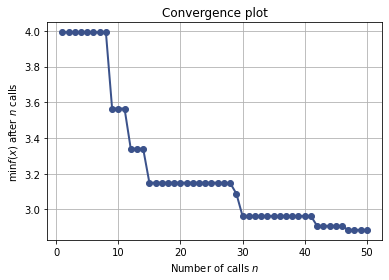

In [21]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

plt.savefig("./plots_optimize/convergence_plot.jpg")
plt.savefig("./plots_optimize/convergence_plot.png")

## 3. Miscellaneous examples

### 3.1 Async optimization Loop

In [22]:
print(__doc__)

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


#### The Setup

In [23]:
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer

noise_level = 0.1

In [24]:
def objective(x, noise_level = noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

def objective_wo_noise(x, noise_level = 0):
    return objective(x, noise_level = 0)

Here a quick plot to visualize what the function looks like:

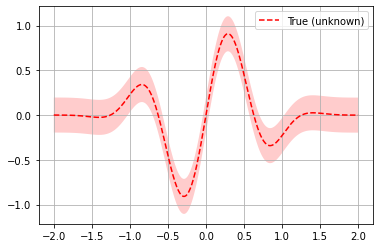

In [25]:
# plot f(x) + contours
plt.set_cmap("viridis")
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = np.array([objective(x_i, noise_level = 0.0) for x_i in x])
plt.plot(x, fx, "r--", label = "True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate(([fx_i - 1.9600 * noise_level for fx_i in fx],
                         [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]] )),
        alpha = .2, fc = "r", ec = "None")
plt.legend()
plt.grid()
plt.savefig("./plots_optimize/3.1.1.jpg")
plt.savefig("./plots_optimize/3.1.1.png")

In [26]:
opt = Optimizer([(-2.0, 2.0)], "GP", acq_func = "EI", acq_optimizer = "sampling", initial_point_generator = "lhs")

In [27]:
next_x = opt.ask()
print(next_x)

[-0.7315058981975282]


In [28]:
f_val = objective(next_x)
opt.tell(next_x, f_val)

          fun: 0.20718649236432957
    func_vals: array([0.20718649])
       models: []
 random_state: RandomState(MT19937) at 0x211263B8640
        space: Space([Real(low=-2.0, high=2.0, prior='uniform', transform='normalize')])
        specs: {'args': {'dimensions': [(-2.0, 2.0)], 'base_estimator': 'GP', 'n_random_starts': None, 'n_initial_points': 10, 'initial_point_generator': 'lhs', 'n_jobs': 1, 'acq_func': 'EI', 'acq_optimizer': 'sampling', 'random_state': None, 'model_queue_size': None, 'acq_func_kwargs': None, 'acq_optimizer_kwargs': None}, 'function': 'Optimizer'}
            x: [-0.7315058981975282]
      x_iters: [[-0.7315058981975282]]

In [29]:
for i in range(9):
    next_x = opt.ask()
    f_val = objective(next_x)
    res = opt.tell(next_x, f_val)

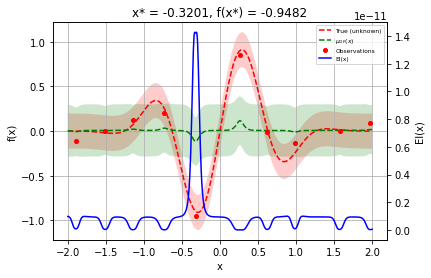

In [30]:
_ = plot_gaussian_process(res, objective = objective_wo_noise,
                         noise_level = noise_level,
                         show_next_point = False,
                         show_acq_func = True)

plt.savefig("./plots_optimize/3.1.2.jpg")
plt.savefig("./plots_optimize/3.1.2.png")

Let us sample a few more points and plot the optimizer again:

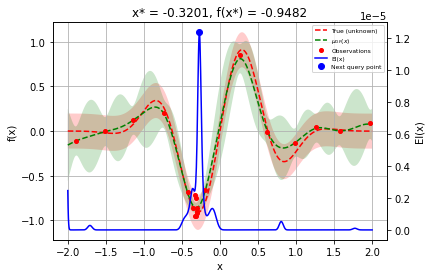

In [31]:
for i in range(10):
    next_x = opt.ask()
    f_val = objective(next_x)
    res = opt.tell(next_x, f_val)
    
_ = plot_gaussian_process(res, objective = objective_wo_noise, 
                         noise_level = noise_level, 
                         show_next_point = True, 
                         show_acq_func = True)

plt.savefig("./plots_optimize/3.1.3.jpg")
plt.savefig("./plots_optimize/3.1.3.png")

Optimizer 저장하고 싶을 때

```python
import pickle

with open('my-optimizer.pkl', 'wb') as f:
    pickle.dump(opt, f)

with open('my-optimizer.pkl', 'rb') as f:
    opt_restored = pickle.load(f)
```

### 3.2 Comparing surrogate models

In [32]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


#### Toy model

In [33]:
from skopt.benchmarks import branin as _branin

def branin(x, noise_level = 0.):
    return _branin(x) + noise_level * np.random.randn()

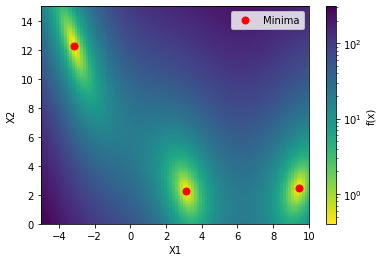

In [34]:
from matplotlib.colors import LogNorm

def plot_branin():
    fig, ax = plt.subplots()
    
    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin(val) for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx, norm = LogNorm(vmin = fx.min(), vmax = fx.max()), cmap = 'viridis_r')
    
    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize = 14, lw = 0, label = "Minima")
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    ax.legend(loc = "best", numpoints = 1)
    
    ax.set_xlabel("X1")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("X2")
    ax.set_ylim([0, 15])
    
plot_branin()
plt.savefig("./plots_optimize/3.2.1.jpg")
plt.savefig("./plots_optimize/3.2.1.png")

#### Objective

In [35]:
from functools import partial
from skopt import gp_minimize, forest_minimize, dummy_minimize

func = partial(branin, noise_level = 2.0)
bounds = [(-5.0, 10.0), (0.0, 15.0)]
n_calls = 60

In [36]:
def run(minimizer, n_iter = 5):
    return [minimizer(func, bounds, n_calls = n_calls, random_state = n)
           for n in range(n_iter)]

# Random search
dummy_res = run(dummy_minimize)

# Gaussian processes
gp_res = run(gp_minimize)

# Random forest
rf_res = run(partial(forest_minimize, base_estimator = "RF"))

# Extra trees
et_res = run(partial(forest_minimize, base_estimator = "ET"))

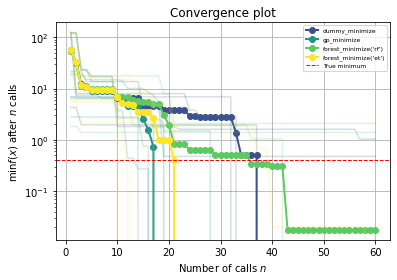

In [37]:
from skopt.plots import plot_convergence

plot = plot_convergence(("dummy_minimize", dummy_res),
                        ("gp_minimize", gp_res),
                        ("forest_minimize('rf')", rf_res),
                        ("forest_minimize('et')", et_res),
                        true_minimum = 0.397887, yscale = "log")

plot.legend(loc = "best", prop = {'size': 6}, numpoints = 1)
plt.savefig("./plots_optimize/3.2.2.jpg")
plt.savefig("./plots_optimize/3.2.2.png")

### 3.3 Bayesian optimization with skopt

#### Problem statement

문제 정의 

$$x^* = arg\min_{x}f(x)$$

* f는 닫힌 형태가 알려져 있지 않은 블랙박스 함수
* 평가하는데 비용이 많이 들며
* $y = f(x)$ 평가는 노이즈를 내포함

※ 다만, 이러한 제약조건이 없다면 베이지안 최적화보다 더 적합한 알고리즘을 사용할 수 있음 

#### Bayesian optimization loop

t = 1부터 T까지 

1. 1부터 T지점까지 주어진 관측치($x_i, y_i = f(x_i))$)에 대한 목적함수 f에 대한 확률 모델 수립

2. 다음 지점을 샘플링을 위한 사후 분포 기반 cheap acquisition/utility 함수 $u$ 최적화

3. 다음 지점 $x_{t+1}$에서의 관측치 $y_{t+1}$ 샘플링

#### Acquisition functions

샘플 $x$에 대한 획득함수$u(x)$에 대해 다음 과정을 수행

* 기대된 향상값(default): $-EI(x) = -\mathbb{E} \left[ f(x)-f(x_{i}^{+})\right]$

* Lower confidence bound: $LCB(x) = \mu_{gp(x)} + \kappa_{\sigma_{GP(x)}}$

* Probability of improvement: $-PI(x) = -P(f(x) \ge f(x_{i}^{+}) + \kappa$

$x_{i}^{+}$에서 최적점 관찰

#### Acquisition functions

In [38]:
print(__doc__)

import numpy as np 
np.random.seed(237)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


#### Toy example

noisy function $f$ 정의

* skopt에서 $f$의 입력은 1D vector로 가정, scala 값을 return 함

In [39]:
noise_level = 0.1 

def f(x, noise_level = noise_level):
    return np.sin(5*x[0])*(1 - np.tanh(x[0]**2)) + np.random.randn()*noise_level

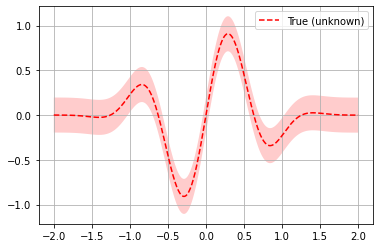

In [40]:
# plot f(x) + contours
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = [f(x_i, noise_level = 0.0) for x_i in x]
plt.plot(x, fx, "r--", label="True (unknown)")
plt.fill(np.concatenate([x, x[::-1]]),
        np.concatenate(([fx_i -1.9600 * noise_level for fx_i in fx],
                       [fx_i + 1.9600 * noise_level for fx_i in fx[::-1]])),
        alpha=.2, fc = "r", ec = "None")
plt.legend()
plt.grid()
plt.savefig("./plots_optimize/3.3.1.jpg")
plt.savefig("./plots_optimize/3.3.1.png")

가우시안 프로세스 회귀를 기반으로한 베이지안 최적화는 gp_minimize 함수 내에서 이행된다.

In [41]:
from skopt import gp_minimize

res = gp_minimize(f, # 최소값을 찾을 함수  
                  [(-2.0, 2.0)],  # x의 바운더리 설정 
                  acq_func = "EI", # 획득 함수 종류 설정 
                  n_calls = 15, # f 의 평가 횟수
                  n_random_starts = 5, # 랜덤 초기화 포인트의 수 
                  noise = 0.1**2, # 노이즈 레벨
                  random_state=1234 # 랜덤 시드
                 )

https://scikit-optimize.github.io/stable/auto_examples/bayesian-optimization.html#sphx-glr-auto-examples-bayesian-optimization-py

Accordingly, the approximated minimum is found to be:

In [42]:
"x^*=%.4f, f(x^*)=%.4f" % (res.x[0], res.fun)

'x^*=-0.3552, f(x^*)=-1.0079'

**`res`** 의 attributes

* **`x`** : 최소점의 위치
* **`fun`** : 최소점에서의 함수값
* **`models`** : 각 반복(iteration)에서의 서로게이트(surrogate models)
* **`x_iters`** : 각 반복(iteration)에서의 함수 평가점(x 값)의 위치
* **`func_vals`** : 각 반복(iteration)에서의 함수값 
* **`space`** : 최적공간(optimization space)
* **`specs`** : 파라미터

In [43]:
print(res)

          fun: -1.0079192525242302
    func_vals: array([ 0.03716044,  0.00673852,  0.63515442, -0.16042062,  0.10695907,
       -0.24436726, -0.58630532,  0.05238726, -1.00791925, -0.98466748,
       -0.86259916,  0.18102445, -0.10782771,  0.00815673, -0.79756403])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True, random_state=822569775), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=0.01),
                         n_restarts_optimizer=2, noise=0.010000000000000002,
                         normalize_y=True

res의 attributes를 이용해 최소점을 찾는 것을 시각화해 볼 수 있음

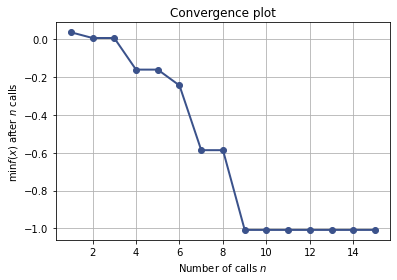

In [44]:
from skopt.plots import plot_convergence
plot_convergence(res)
plt.savefig("./plots_optimize/3.3.2.jpg")
plt.savefig("./plots_optimize/3.3.2.png")

다음과 같이 시각화 실시 

1. 오리지널 함수에 대한 gp 모델의 적합 근사값

2. 다음 포인트를 정하기 위한 획득(함수의) 값

In [45]:
plt.rcParams["figure.figsize"] = (8 ,14)

def f_wo_noise(x):
    return f(x, noise_level = 0)

5개의 랜덤 포인트를 따라 5회 반복 실시

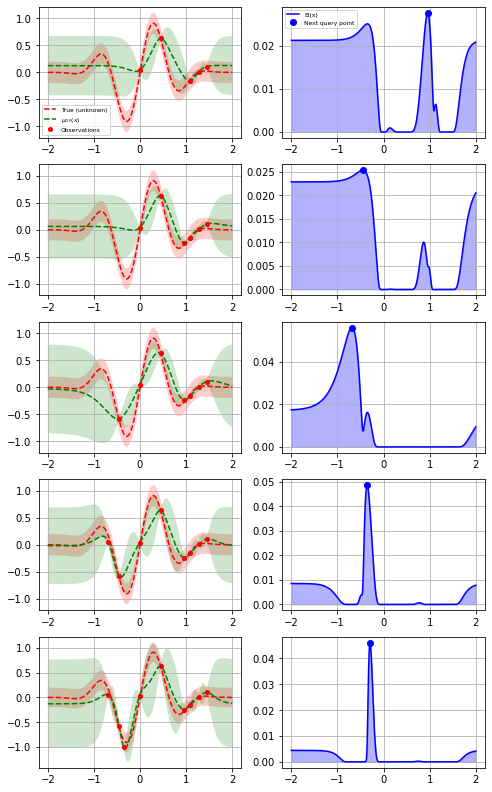

In [46]:
for n_iter in range(5):
    # plot true function 
    plt.subplot(5, 2, 2*n_iter + 1)
    
    if n_iter == 0:
        show_legend = True
    else:
        show_legend = False
        
    ax = plot_gaussian_process(res,
                              n_calls = n_iter,
                              objective = f_wo_noise,
                              noise_level = noise_level,
                              show_legend = show_legend,
                              show_title = False,
                              show_next_point = False,
                              show_acq_func = False)
    
    ax.set_ylabel("")
    ax.set_xlabel("")
    # Plot EI(x)
    plt.subplot(5, 2, 2*n_iter + 2)
    ax = plot_gaussian_process(res,
                              n_calls = n_iter,
                              show_legend = show_legend,
                              show_title = False,
                              show_mu = False,
                              show_acq_func = True,
                              show_observations = False,
                              show_next_point = True)
    
    ax.set_ylabel("")
    ax.set_xlabel("")

plt.savefig("./plots_optimize/3.3.3.jpg")
plt.savefig("./plots_optimize/3.3.3.png")

왼편 그래프들이 나타내는 것들

1. 실제 함수(true function)
2. 가우시안 프로세스 모델의 근사값(원함수(original function)에 대한)
3. 가우시안 프로세스가 확신하는 과정

오른편 그래프들이 보여주는 것은 매 서로게이트 모델이 피팅되고 난 후의 획득함수의 값.
이를 통해 전역 최소값(global minimum)은 선택하지는 못하나, 획득함수를 최소화하는 지역 최소값(local minimum)을 찾을 수는 있음
이전에 평가된 점에서 다음 평가점으로 갈수록 분산은 0에 가까워짐
마지막으로 평가 포인트의 수를 늘릴수록 가우시안 프로세스(GP) 모델은 실제 함수에 가까워짐. 
-> 마지막 몇 개의 점은 최소점에서 그룹을 이룬다. (왜냐면 가우시안 프로세스 모델이 추가 탐색을 통해 더 다른 것을 얻지 못하므로)

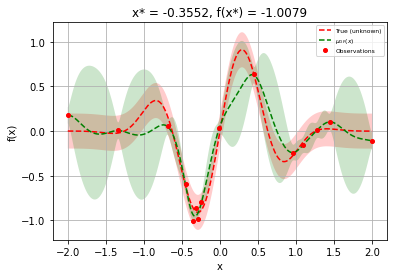

In [47]:
plt.rcParams["figure.figsize"] = (6, 4)

# plot f(x) + contours

_ = plot_gaussian_process(res, 
                         objective = f_wo_noise,
                         noise_level = noise_level)

plt.savefig("./plots_optimize/3.3.4.jpg")
plt.savefig("./plots_optimize/3.3.4.png")

### 3.4 Scikit-learn hyperparameter search wrapper 

* == 1. BayessearchCV와 내용 동일

### 3.5 Exploration vs exploitation

추정 모델(surrogate model)을 기반으로 탐색할 파라미터를 선택할 때 평균이 큰 것을 선택하는 전략을 exploitation이라고 하고, 분산이 큰 것을 선택하는 전략을 exploration이라고 한다. 

#### Toy example

In [48]:
print(__doc__)

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from skopt.plots import plot_gaussian_process

Automatically created module for IPython interactive environment


In [49]:
noise_level = 0.1 

# Out 1D toy problem, this is the function we are trying to minimize

def objective(x, noise_level = noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

def objective_wo_noise(x):
    return objective(x, noise_level = 0)

In [50]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 3, acq_optimizer = "sampling")

Plotting parameters

In [51]:
plot_args = {"objective": objective_wo_noise,
             "noise_level": noise_level, 
             "show_legend": True,
             "show_title": True,
             "show_next_point": False,
             "show_acq_func": True}

스탠다드 세팅으로 최적화 루프를 실행

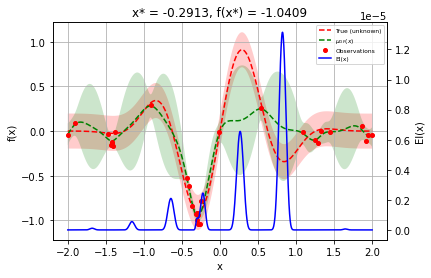

In [52]:
for i in range(30):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)
# The same output could be created with opt.run(objective, n_iter = 30)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.1.png")

$\kappa$와 $x_i$ 에 대해 다른 값을 설정

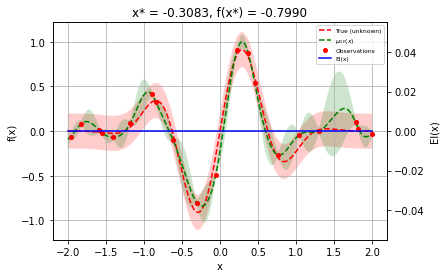

In [53]:
acq_func_kwargs = {"xi": 10000, "kappa": 10000}

opt = Optimizer([(-2.0, 2.0)], 
                "GP", 
                n_initial_points = 3,
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.2.png")

acq_func = "LCB"로 바꾸면 

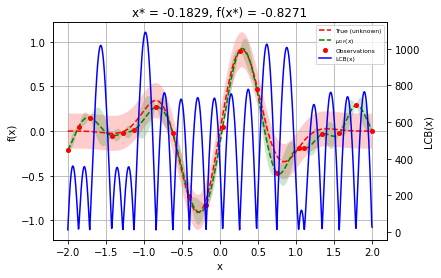

In [54]:
opt = Optimizer([(-2.0, 2.0)], 
                "GP",
                n_initial_points = 3,
                acq_func = "LCB",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.3.png")

acq_func = "PI"

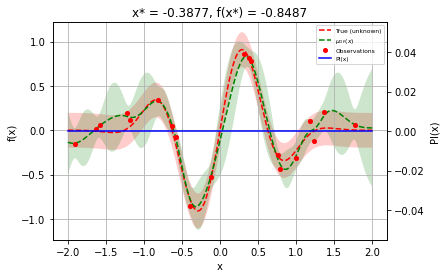

In [55]:
opt = Optimizer([(-2.0, 2.0)],
                "GP",
                n_initial_points = 3,
                acq_func = "PI",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.4.png")

We can also favor exploitation

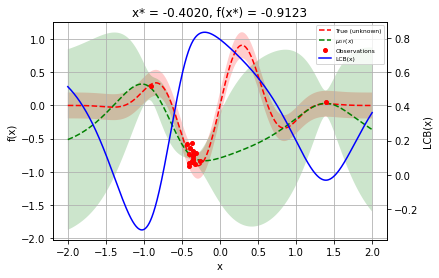

In [56]:
acq_func_kwargs = {"xi": 0.000001, "kappa": 0.001}

opt = Optimizer([(-2.0, 2.0)], 
                "GP", 
                n_initial_points = 3,
                acq_func = "LCB",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.5.png")

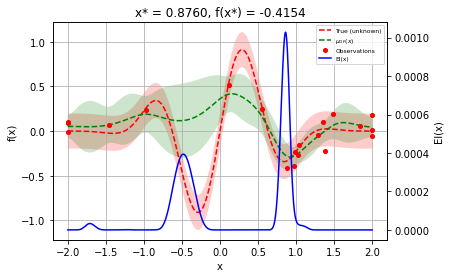

In [57]:
opt = Optimizer([(-2.0, 2.0)],
                "GP",
                n_initial_points = 3,
                acq_func = "EI",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.6.png")

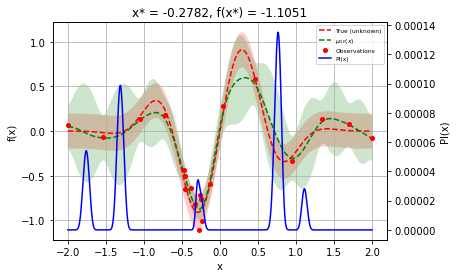

In [58]:
opt = Optimizer([(-2.0, 2.0)],
                "GP",
                n_initial_points = 3,
                acq_func = "PI",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.7.png")

xi가 범위 밖의 음수일 때는 PI acquisition function이 작동치 않음, 왜냐면 확률은 0 ~ 1 사이의 범위이니까

- 다만 EI는 작동함

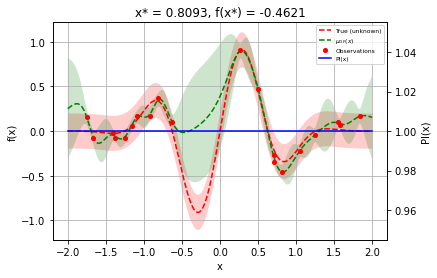

In [59]:
acq_func_kwargs = {"xi" : -1000}

opt = Optimizer([(-2.0, 2.0)], 
                "GP", 
                n_initial_points = 3,
                acq_func = "PI",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.8.png")    

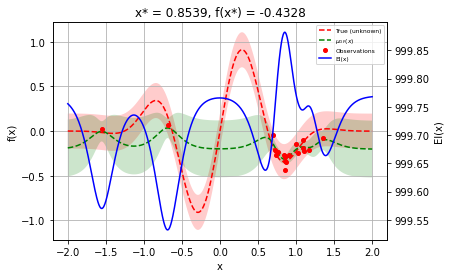

In [60]:
opt = Optimizer([(-2.0, 2.0)], 
                "GP",
                n_initial_points= 3,
                acq_func = "EI",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.9.png")   

최적화 진행 중 kappa 또는 ki를 변경하려면 opt.acq_func_kwargs를 교체
- 다음 포인트에서 다시 계산하려면 변경 후 opt.update_next() 호출

In [61]:
acq_func_kwargs = {"kappa" : 0}
opt = Optimizer([(-2.0, 2.0)],
                "GP",
                n_initial_points = 3,
                acq_func = "LCB",
                acq_optimizer = "sampling",
                acq_func_kwargs = acq_func_kwargs)

opt.acq_func_kwargs

{'kappa': 0}

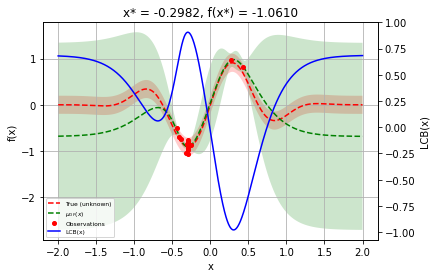

In [62]:
opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.10.png")

In [63]:
acq_func_kwargs = {"kappa" : 100000}

In [64]:
opt.acq_func_kwargs = acq_func_kwargs
opt.update_next()

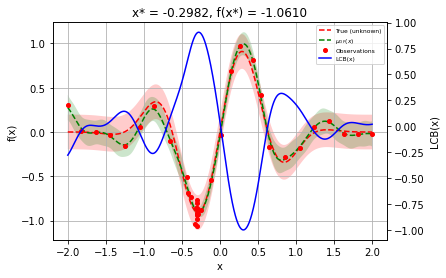

In [65]:
opt.run(objective, n_iter = 20)
_ = plot_gaussian_process(opt.get_result(), **plot_args)
plt.savefig("./plots_optimize/3.5.11.png")

### 3.6 Use different base estimators for optimization

In [66]:
print(__doc__)

import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from skopt.plots import plot_gaussian_process
from skopt import Optimizer

Automatically created module for IPython interactive environment


#### Toy example

noisy function $f$ 정의

In [67]:
noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to minimize

def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2))\
           + np.random.randn() * noise_level

def objective_wo_noise(x):
    return objective(x, noise_level=0)

In [68]:
opt_gp = Optimizer([(-2.0, 2.0)],
                   base_estimator = "GP",
                   n_initial_points = 5, 
                   acq_optimizer = "sampling",
                   random_state = 42)

In [69]:
def plot_optimizer(res, n_iter, max_iters = 5):
    if n_iter == 0:
        show_legend = True
    else: 
        show_legend = False
    ax = plt.subplot(max_iters, 2, 2*n_iter + 1)
    # plot GP(x) + contours
    ax = plot_gaussian_process(res,
                               ax = ax,
                               objective = objective_wo_noise, 
                               noise_level = noise_level,
                               show_legend = show_legend,
                               show_title = True,
                               show_next_point = False,
                               show_acq_func = False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])
    # plot EI(x)
    ax = plt.subplot(max_iters, 2, 2 * n_iter + 2)
    ax = plot_gaussian_process(res,
                               ax = ax,
                               noise_level = noise_level, 
                               show_legend = show_legend,
                               show_title = False,
                               show_next_point = True,
                               show_acq_func = True,
                               show_observatioins = False,
                               show_mu = False)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if n_iter < max_iters - 1:
        ax.get_xaxis().set_ticklabels([])

#### GP kernel

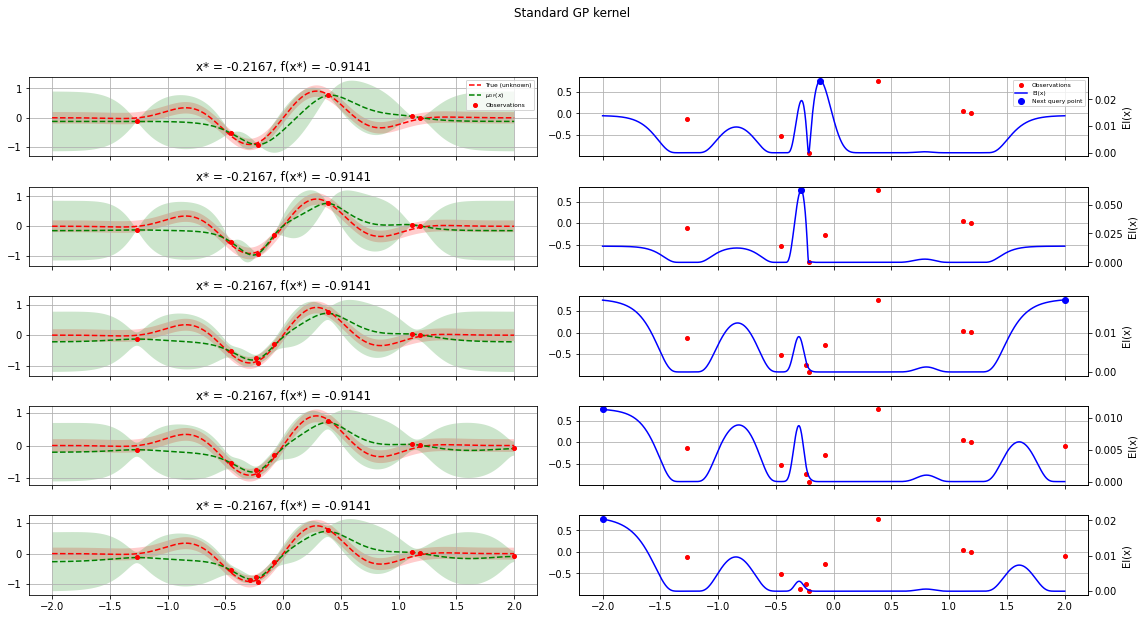

In [70]:
fig = plt.figure(figsize=(16,9))
fig.suptitle("Standard GP kernel")
for i in range(10):
    next_x = opt_gp.ask()
    f_val = objective(next_x)
    res = opt_gp.tell(next_x, f_val)
    if i >= 5:
        plot_optimizer(res, n_iter = i-5, max_iters = 5)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.savefig("./plots_optimize/3.6.1.png")

#### Test different kernels

In [71]:
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
# Gaussian process with Matern kernel as surrogate model

from sklearn.gaussian_process.kernels import (RBF, Matern, 
                                              RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

kernels = [1.0 * RBF(length_scale = 1.0, length_scale_bounds = (1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale = 1.0, alpha = 0.1),
           1.0 * ExpSineSquared(length_scale = 1.0, periodicity= 3.0,
                                length_scale_bounds = (0.1, 10.0),
                                periodicity_bounds = (1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))*(DotProduct(sigma_0 = 1.0, sigma_0_bounds=(0.1, 10.0))**2),
           1.0 * Matern(length_scale = 1.0, length_scale_bounds=(1e-1, 10.0), nu = 2.5)]


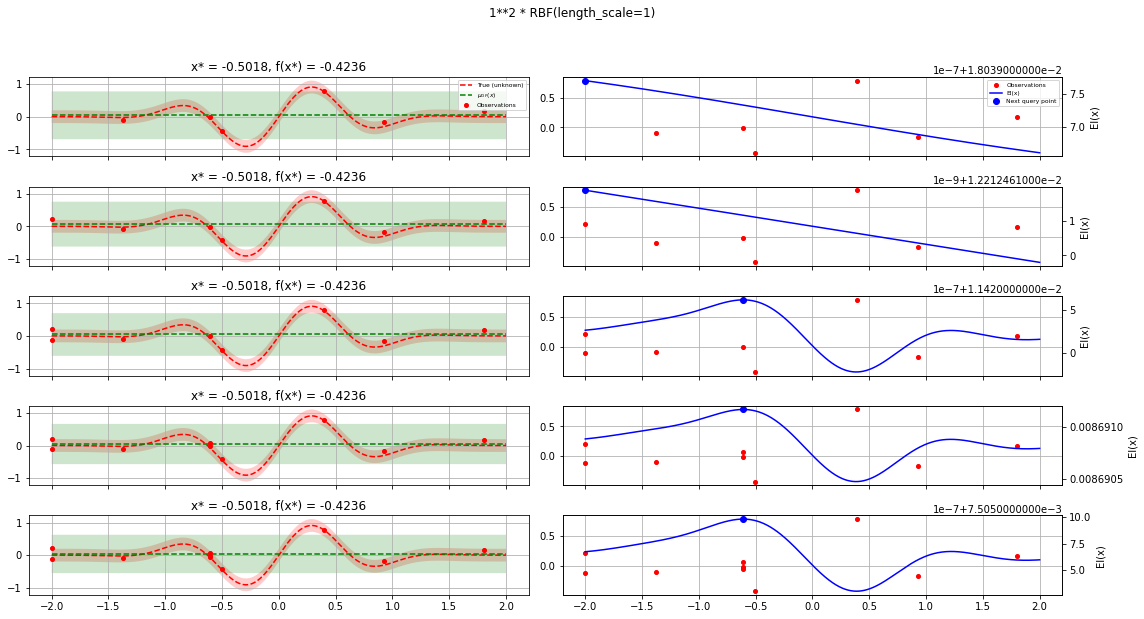

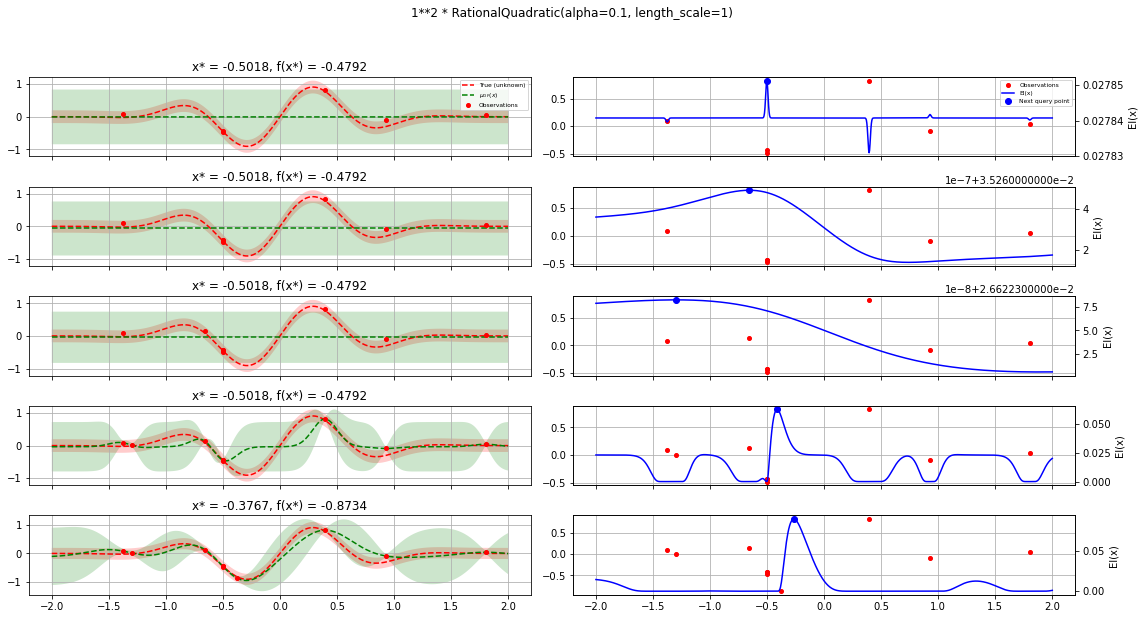

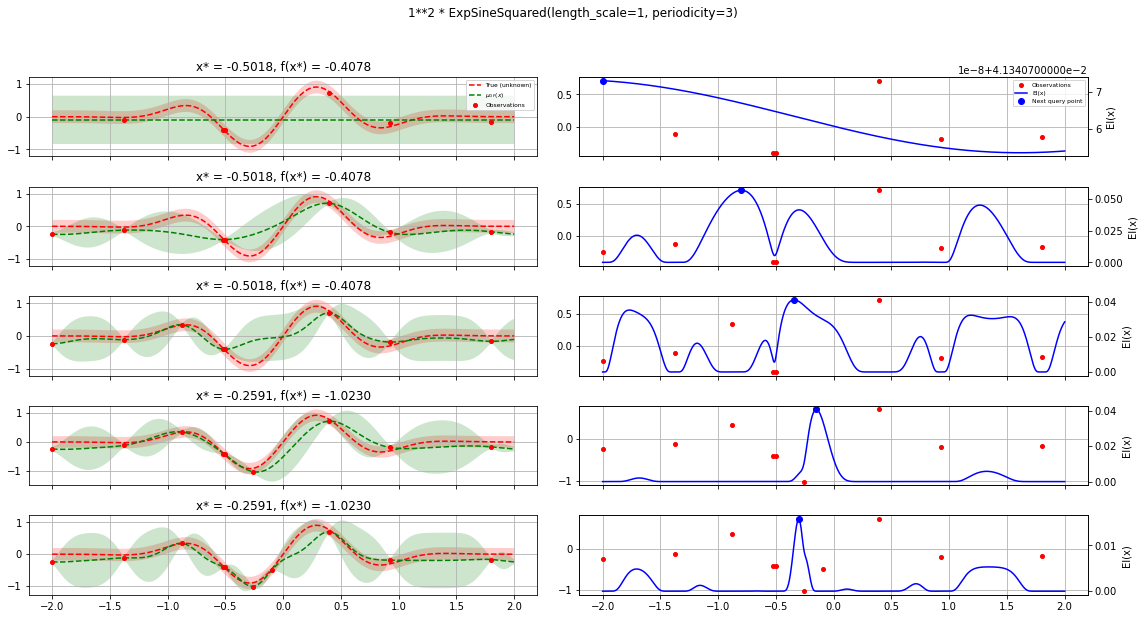

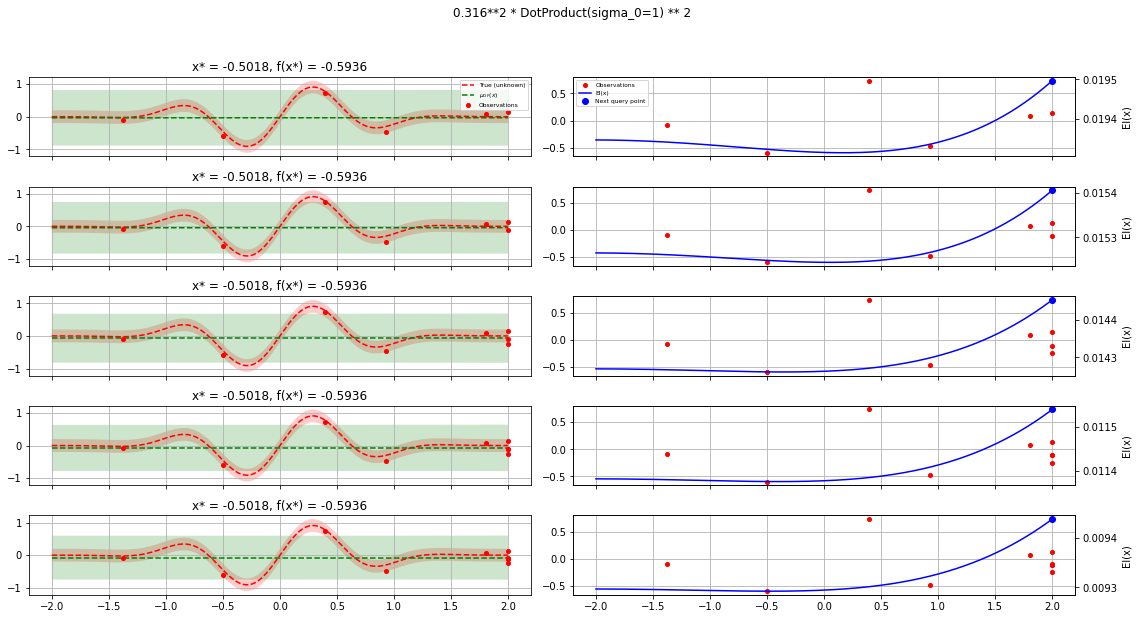

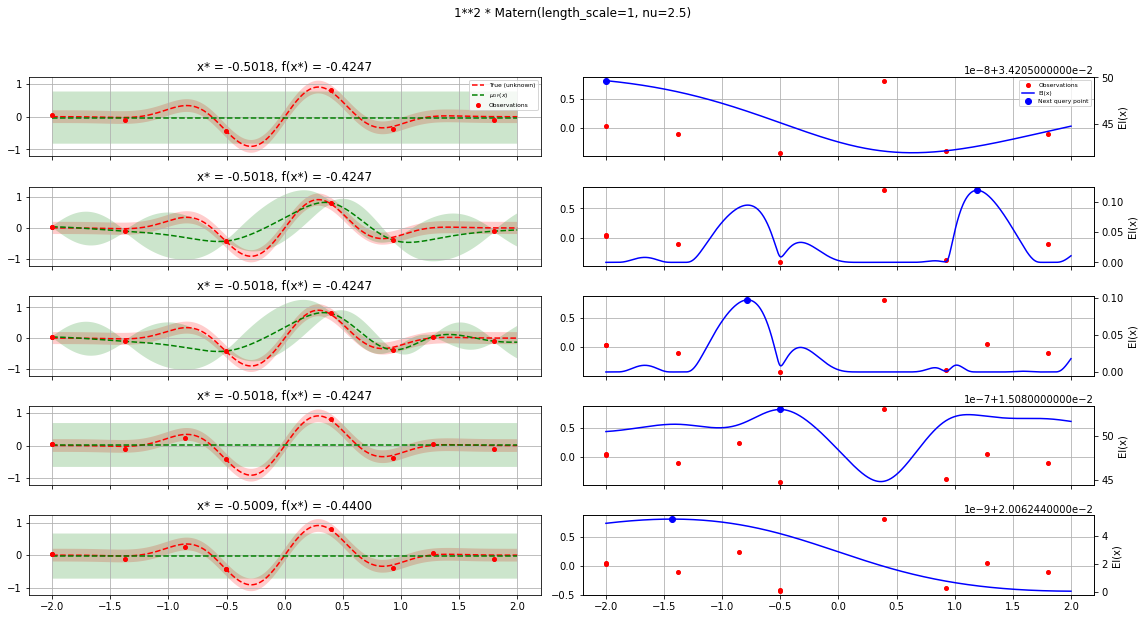

In [72]:
for kernel in kernels:
    gpr = GaussianProcessRegressor(kernel = kernel,
                                   alpha = noise_level ** 2,
                                   normalize_y = True, 
                                   noise = "gaussian",
                                   n_restarts_optimizer = 2)
    opt = Optimizer([(-2.0, 2.0)],
                    base_estimator = gpr, 
                    n_initial_points = 5,
                    acq_optimizer = "sampling", 
                    random_state = 42)
    fig = plt.figure(figsize=(16,9))
    fig.suptitle(repr(kernel))
    for i in range(10):
        next_x = opt.ask()
        f_val = objective(next_x)
        res = opt.tell(next_x, f_val)
        if i >= 5:
            plot_optimizer(res, n_iter = i - 5, max_iters = 5)
    plt.tight_layout(rect = [0, 0.03, 1, 0.95])
    plt.savefig("./plots_optimize/3.6.2-"+ str(kernel.k2).split('(')[0] +".png")